In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import leaguegamefinder, teamdashboardbygeneralsplits, playercareerstats
from nba_api.stats.endpoints import leagueleaders
from nba_api.stats.static import teams, players
import seaborn as sns

In [70]:
# Function to clean column names
def clean_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('%', 'pct')
    return df

In [71]:
#1. Get Game-Level Data
def get_games(seasons):
    gamefinder = leaguegamefinder.LeagueGameFinder()
    games = gamefinder.get_data_frames()[0]
    games['game_date'] = pd.to_datetime(games['GAME_DATE']) 
    games = games[games['game_date'].dt.year.isin(seasons)]  # Filter by seasons (making sure its 2023 or 2024)
    games = clean_column_names(games)  # Clean column names
    return games

In [72]:
# 2. Fetch Team Stats
def get_team_stats():
    team_list = teams.get_teams() #teams object has a built-in get_teams() method which returns a list of all the nba teams as a dictionary 
    team_stats = [] 
    for team in team_list:
        team_dashboard = teamdashboardbygeneralsplits.TeamDashboardByGeneralSplits(team_id=team['id']) #team object has a built-in TeamDashboardByGeneralSplits() method which returns a team's stats-->team_dashboard now holds the stats of the given team
        team_df = team_dashboard.get_data_frames()[0] #turning the data into a dataframe
        team_df['team_name'] = team['full_name']  # Add team name
        team_stats.append(clean_column_names(team_df))
    return pd.concat(team_stats, ignore_index=True)

In [73]:
def get_player_stats(season):
    player_list = players.get_players()
    player_stats = []
    for player in player_list[:50]:  # Limit to first 50 players for demo (avoid API throttling)
        try:
            player_career = playercareerstats.PlayerCareerStats(player_id=player['id'])
            player_df = player_career.get_data_frames()[0]
            player_df['player_name'] = player['full_name']  # Add player name
            player_stats.append(clean_column_names(player_df))
        except Exception as e:
            print(f"Failed for {player['full_name']}: {e}")
    return pd.concat(player_stats, ignore_index=True)

In [74]:
# 4. get League Leaders in points 
def fetch_league_leaders(stat_category='PTS'):
    leaders = leagueleaders.LeagueLeaders(stat_category_abbreviation=stat_category)
    leader_data = leaders.get_data_frames()[0]
    return clean_column_names(leader_data)

In [75]:
# 5. combining all the functions above 
def combine_data(seasons):
    games = get_games(seasons)
    print(f"Success: got {len(games)} games for {seasons}.")
    
    team_stats = get_team_stats()
    print(f"Success: got team stats for {len(team_stats)} teams.")
    
    player_stats = get_player_stats(season=max(seasons))
    print(f"Success: got player stats for {len(player_stats)} players.")
    
    league_leaders = get_league_leaders()
    print("Success: got league leaders.")
    
    # saving data to different csvs
    games.to_csv('games_cleaned.csv', index=False)
    team_stats.to_csv('team_stats_cleaned.csv', index=False)
    player_stats.to_csv('player_stats_cleaned.csv', index=False)
    league_leaders.to_csv('league_leaders_cleaned.csv', index=False)
    print("Data saved to CSV.")
    
    return games, team_stats, player_stats, league_leaders

In [76]:
if __name__ == "__main__":
    SEASONS = [2023, 2024] 
    games, team_stats, player_stats, league_leaders = combine_data(SEASONS)

Success: got 16080 games for [2023, 2024].
Success: got team stats for 30 teams.
Failed for Zaid Abdul-Aziz: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Failed for Tariq Abdul-Wahad: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Failed for Forest Able: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Failed for John Abramovic: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Failed for Precious Achiuwa: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Failed for Donald Ackerman: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Failed for Alvan Adams: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Failed for Jaylen Adams: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Fa

KeyboardInterrupt: 

In [92]:
league_leaders = pd.read_csv('league_leaders_cleaned.csv')
player_stats = pd.read_csv('player_stats_cleaned.csv')
team_stats = pd.read_csv('team_stats_cleaned.csv')
games = pd.read_csv('games_cleaned.csv') 




In [93]:
# 1. Separate the data into winning and losing teams based on win percentage 
winning_teams = team_stats[team_stats['w_pct'] > 0.5]
losing_teams = team_stats[team_stats['w_pct'] < 0.5]

# 2.compare stats for winning teams & losing teams (these are our features)
# winning teams 
winning_stats = winning_teams[['pts', 'plus_minus', 'reb', 'ast', 'tov']].describe()

# losing teams
losing_stats = losing_teams[['pts', 'plus_minus', 'reb', 'ast', 'tov']].describe()

In [94]:
# 3. getting more features to analyze performance (in addition to pts, plus_minus, reb, etc.)
# Turnover-to-Assist Ratio
winning_teams['to_assist_ratio'] = winning_teams['tov'] / winning_teams['ast']
losing_teams['to_assist_ratio'] = losing_teams['tov'] / losing_teams['ast']

# Rebound-to-Points Ratio
winning_teams['reb_points_ratio'] = winning_teams['reb'] / winning_teams['pts']
losing_teams['reb_points_ratio'] = losing_teams['reb'] / losing_teams['pts']

/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_63775/889759759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_teams['to_assist_ratio'] = winning_teams['tov'] / winning_teams['ast']
/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_63775/889759759.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losing_teams['to_assist_ratio'] = losing_teams['tov'] / losing_teams['ast']
/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_63775/889759759.py:7: SettingWithCopyWarning

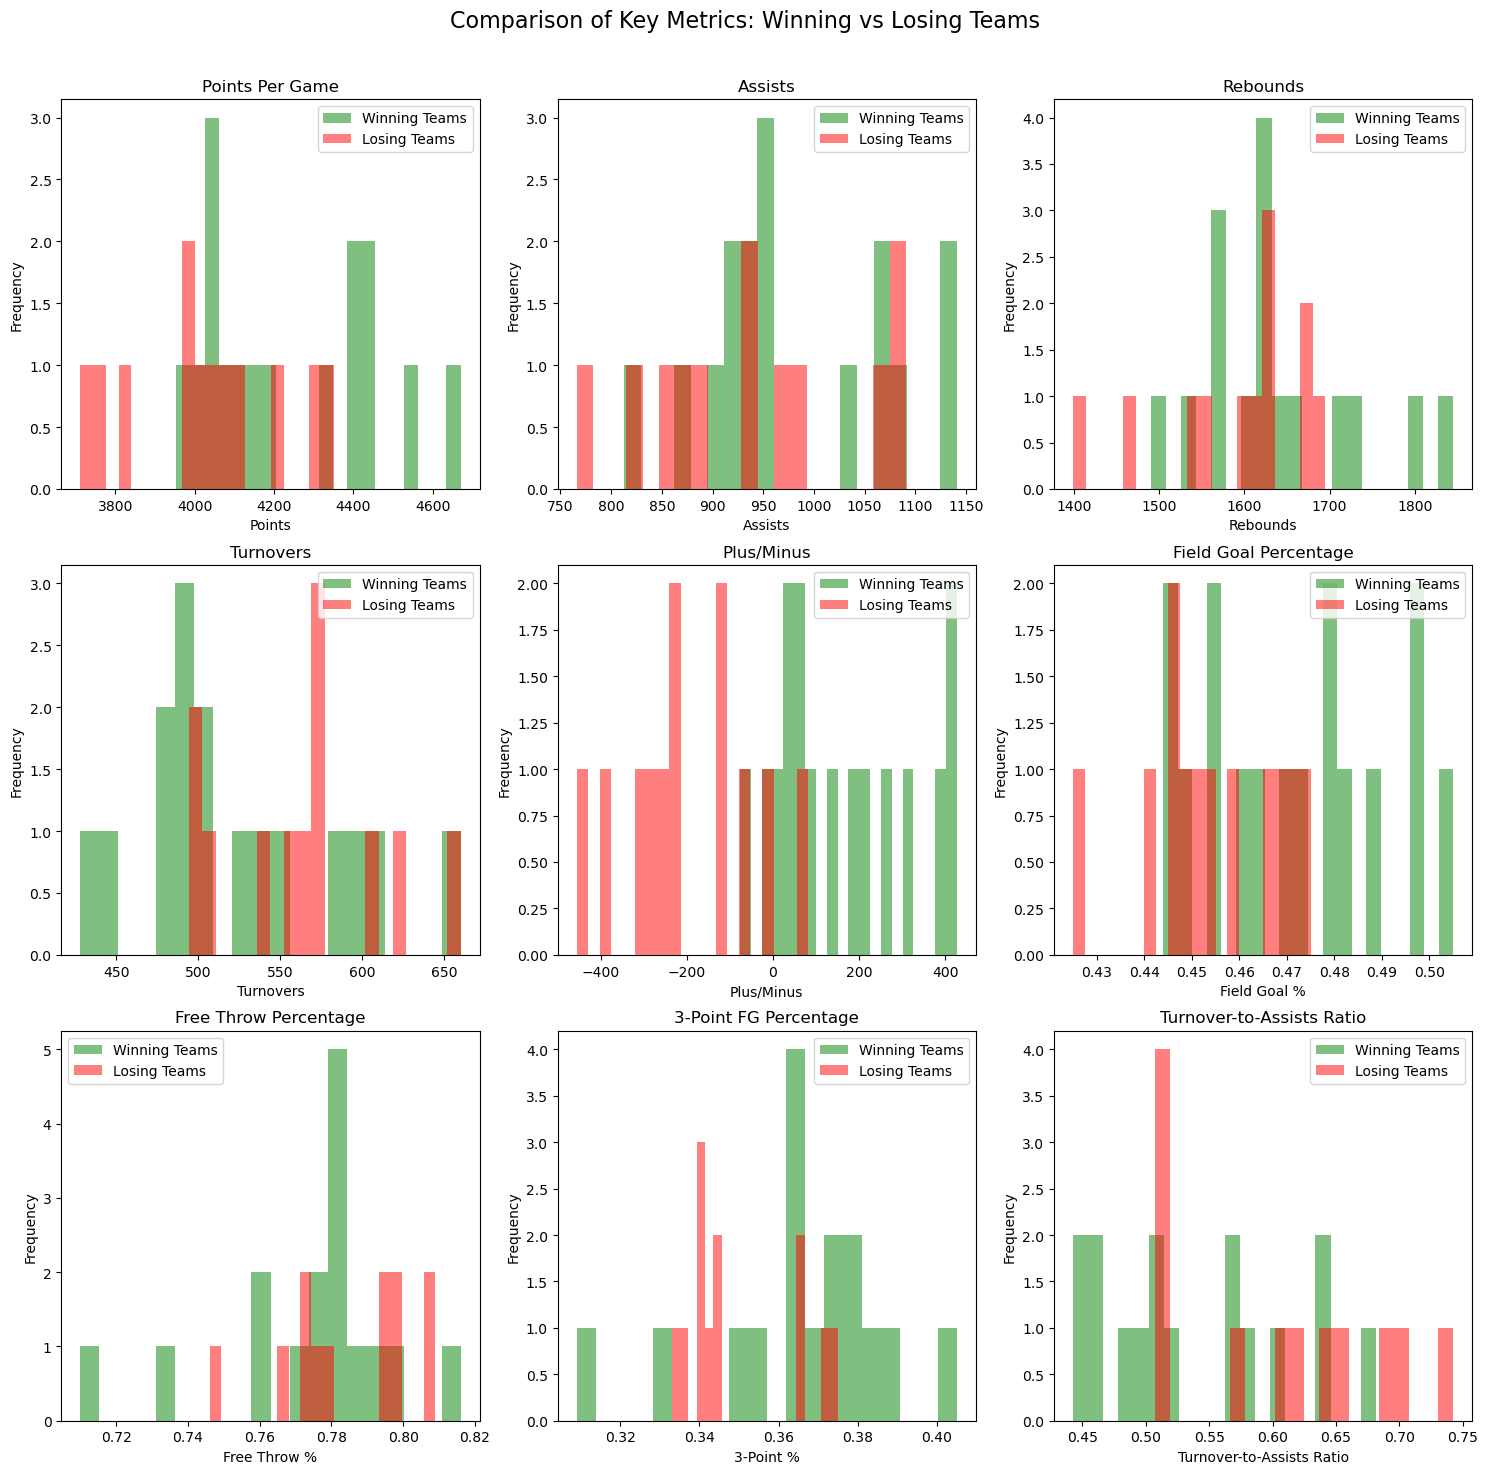

In [98]:
#Creating a histogram for each metric comparing winning and losing teams

# 3x3 grid of subplots (for our 9 features)
#note: subplots(__, ___) returns 2 values: fig and axes; 
#note: fig is the entire figure (like a container), axes are the indiviual subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Comparison of Key Metrics: Winning vs Losing Teams', fontsize=16)


#note: axes[__, ___ ] simply states where on the 3x3 grid this histogram will be placed
#note: alpha refers to the transperency of the bars

# Points per game histogram
axes[0, 0].hist(winning_teams['pts'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[0, 0].hist(losing_teams['pts'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[0, 0].set_title('Points Per Game')
axes[0, 0].set_xlabel('Points')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Assists histogram
axes[0, 1].hist(winning_teams['ast'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[0, 1].hist(losing_teams['ast'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[0, 1].set_title('Assists')
axes[0, 1].set_xlabel('Assists')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Rebounds histogram 
axes[0, 2].hist(winning_teams['reb'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[0, 2].hist(losing_teams['reb'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[0, 2].set_title('Rebounds')
axes[0, 2].set_xlabel('Rebounds')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()

# Turnovers histogram
axes[1, 0].hist(winning_teams['tov'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[1, 0].hist(losing_teams['tov'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[1, 0].set_title('Turnovers')
axes[1, 0].set_xlabel('Turnovers')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Plus/Minus histogram 
axes[1, 1].hist(winning_teams['plus_minus'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[1, 1].hist(losing_teams['plus_minus'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[1, 1].set_title('Plus/Minus')
axes[1, 1].set_xlabel('Plus/Minus')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

# Field goal % histogram 
axes[1, 2].hist(winning_teams['fg_pct'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[1, 2].hist(losing_teams['fg_pct'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[1, 2].set_title('Field Goal Percentage')
axes[1, 2].set_xlabel('Field Goal %')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

#Free throw % histogrm 
axes[2, 0].hist(winning_teams['ft_pct'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[2, 0].hist(losing_teams['ft_pct'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[2, 0].set_title('Free Throw Percentage')
axes[2, 0].set_xlabel('Free Throw %')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].legend()

# 3-point  % histogrm 
axes[2, 1].hist(winning_teams['fg3_pct'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[2, 1].hist(losing_teams['fg3_pct'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[2, 1].set_title('3-Point FG Percentage')
axes[2, 1].set_xlabel('3-Point %')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].legend()

# Tov-Ast ratio histogram
axes[2, 2].hist(winning_teams['to_assist_ratio'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[2, 2].hist(losing_teams['to_assist_ratio'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[2, 2].set_title('Turnover-to-Assists Ratio')
axes[2, 2].set_xlabel('Turnover-to-Assists Ratio')
axes[2, 2].set_ylabel('Frequency')
axes[2, 2].legend()

# adjusting the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)  
plt.show()



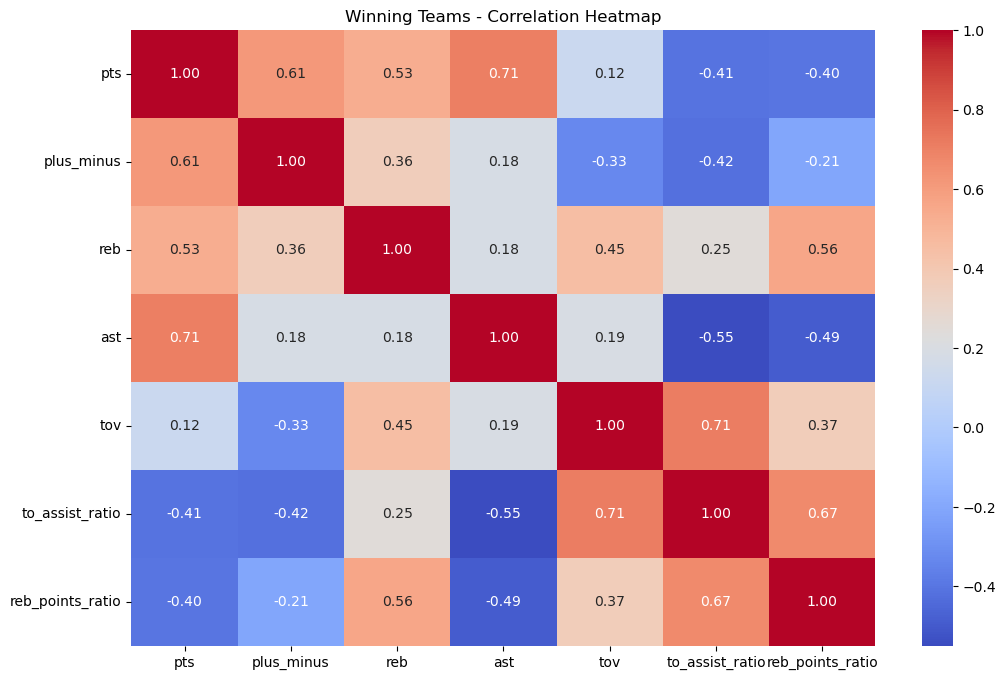

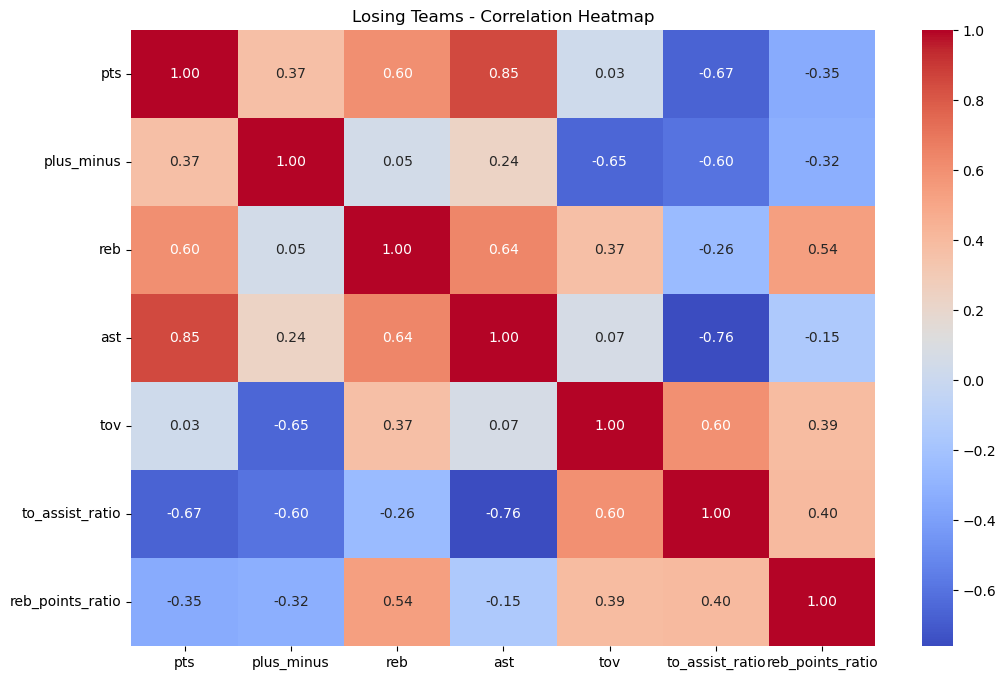

In [99]:

# Using seaborn to visualize difference in key metrics b/w winning & losing teams

# finding overall correlation between performance metrics and win percentage
winning_teams_corr = winning_teams[['pts', 'plus_minus', 'reb', 'ast', 'tov', 'to_assist_ratio', 'reb_points_ratio']].corr()
losing_teams_corr = losing_teams[['pts', 'plus_minus', 'reb', 'ast', 'tov', 'to_assist_ratio', 'reb_points_ratio']].corr()

# Plotting correlation heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(winning_teams_corr, annot=True, cmap='coolwarm', fmt='.2f') #annot=True to show the values in the heatmap; cmap='coolwarm' to use a color gradient; fmt='.2f' to format the values to 2 decimal places
plt.title('Winning Teams - Correlation Heatmap')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(losing_teams_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Losing Teams - Correlation Heatmap')
plt.show()

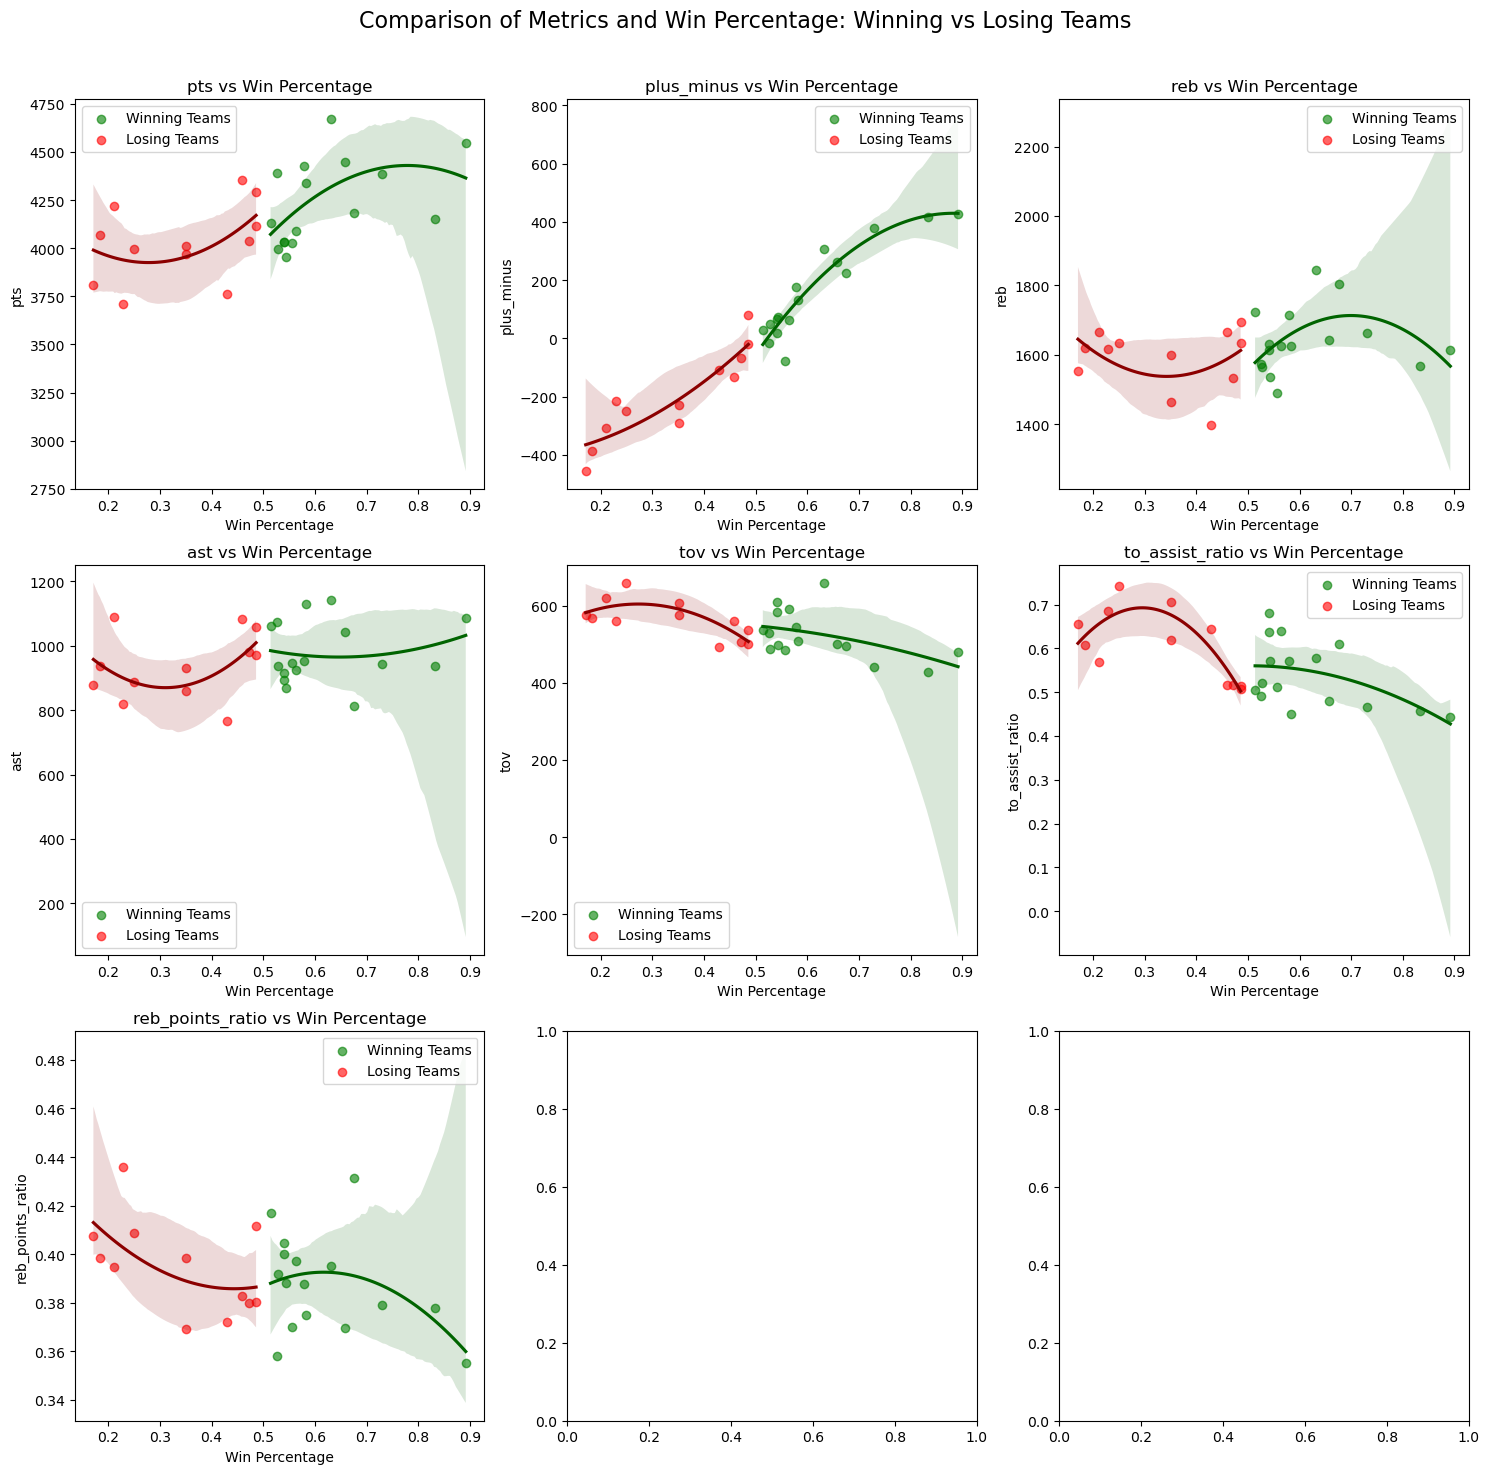

In [105]:
#creating scatterplots to compare each feature with win %
import seaborn as sns
import matplotlib.pyplot as plt

# same features as before
features = ['pts', 'plus_minus', 'reb', 'ast', 'tov', 'to_assist_ratio', 'reb_points_ratio']

# 3x3 grid to dispaly scatterplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Comparison of Metrics and Win Percentage: Winning vs Losing Teams', fontsize=16)

# Loop through each metric and plot a scatter plot with win percentage
for i, feature in enumerate(features):
    row = i // 3  # Determine row in subplot grid
    col = i % 3   # Determine column in subplot grid

    # scatterplot for winning teams
    sns.regplot(x='w_pct', y=feature, data=winning_teams, ax=axes[row, col], 
                scatter_kws={'color': 'green', 'alpha': 0.6}, line_kws={'color': 'darkgreen'}, 
                label='Winning Teams', order=2)  # Fit a quadratic (degree 2) curve

    # scatterplot for losing teams
    sns.regplot(x='w_pct', y=feature, data=losing_teams, ax=axes[row, col], 
                scatter_kws={'color': 'red', 'alpha': 0.6}, line_kws={'color': 'darkred'}, 
                label='Losing Teams', order=2)  # "order =2": quadratic fit

    # plot titles/labels
    axes[row, col].set_title(f'{feature} vs Win Percentage')
    axes[row, col].set_xlabel('Win Percentage')
    axes[row, col].set_ylabel(feature)

    # Add legend
    axes[row, col].legend()

# adjusting layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # To prevent overlap with the title
plt.show()
